In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import xarray as xr

from scipy import stats
from scipy import integrate
from numpy import exp
import math
from pymannkendall import original_test as mk

from osgeo import gdal
import pyhdf
from pyhdf.SD import SD
import geopandas as gpd
import rasterio
import rioxarray as rxr

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors
plt.rcParams['font.family'] = 'Arial'
from matplotlib.ticker import MaxNLocator

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader

In [2]:
inpath = 'C:/Users/bn_li/Desktop/manu1/data/'
outpath = 'D:/figs_manu1/'

## veg type mask

In [3]:
mask = xr.open_dataset(inpath + 'lc.nc')
mask1 = xr.open_dataset(inpath+'spi_mask.nc')

def varimask_forest(ds):

    x = ds.dims['lon']
    y = ds.dims['lat']
    
    mask_a = mask['vari'].values == 1
    mask_b = mask1['vari'].values <= 0
    combined_mask = mask_a & mask_b  # Logical AND
    
    ratio = np.sum(combined_mask) / np.sum(mask_a) * 100
    print(f"Forest mask ratio: {ratio:.2f}%")
    
    anos = np.full_like(ds['vari'].values, np.nan)
    for t in range(ds.dims['time']):    #### change the time length
        vari_t = ds['vari'][t,:,:].values
        vari_masked = np.where(combined_mask, vari_t, np.nan)
        arr = vari_masked.copy() #### exclude sichuan mountaions 
        arr[:80,:51] = np.nan
        anos[t,:,:] = arr
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
    return(ds_ex)

def varimask_shrub(ds):

    x = ds.dims['lon']
    y = ds.dims['lat']
    
    mask_a = mask['vari'].values == 2
    mask_b = mask1['vari'].values <= 0
    combined_mask = mask_a & mask_b  # Logical AND
    
    ratio = np.sum(combined_mask) / np.sum(mask_a) * 100
    print(f"Shrubland mask ratio: {ratio:.2f}%")
    
    anos = np.full_like(ds['vari'].values, np.nan)
    for t in range(ds.dims['time']):    #### change the time length
        vari_t = ds['vari'][t,:,:].values
        vari_masked = np.where(combined_mask, vari_t, np.nan)
        anos[t,:,:] = vari_masked
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
    return(ds_ex)


def varimask_crop(ds):

    x = ds.dims['lon']
    y = ds.dims['lat']
    
    mask_a = mask['vari'].values == 5
    mask_b = mask1['vari'].values <= 0
    combined_mask = mask_a & mask_b  # Logical AND
    
    ratio = np.sum(combined_mask) / np.sum(mask_a) * 100
    print(f"Crop mask ratio: {ratio:.2f}%")
    
    anos = np.full_like(ds['vari'].values, np.nan)
    for t in range(ds.dims['time']):    #### change the time length
        vari_t = ds['vari'][t,:,:].values
        vari_masked = np.where(combined_mask, vari_t, np.nan)
        anos[t,:,:] = vari_masked
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
    return(ds_ex)

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


## veg type analysis

In [4]:
################# LAI  ########################################
ds_y = xr.open_dataset(inpath+'shapley/lai_new_qc_0.05_1d.nc').sel(time=slice('2001-01-01','2022-12-31'))
ds1 = varimask_forest(ds_y)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat1 = y_list.reshape((365, -1), order='F')


ds1 = varimask_shrub(ds_y)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat2 = y_list.reshape((365, -1), order='F')


ds1 = varimask_crop(ds_y)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat3 = y_list.reshape((365, -1), order='F')

C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  y = ds.dims['lat']


Forest mask ratio: 84.22%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:17: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):    #### change the time length
C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:32: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:33: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, pl

Shrubland mask ratio: 87.93%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:43: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):    #### change the time length
C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:57: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:58: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, pl

Crop mask ratio: 41.56%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:68: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):    #### change the time length


In [5]:
################# SIF  ########################################
ds_y = xr.open_dataset(inpath+'shapley/sif_0.05_1d.nc').sel(time=slice('2001-01-01','2022-12-31'))
ds1 = varimask_forest(ds_y)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat4 = y_list.reshape((365, -1), order='F')

ds1 = varimask_shrub(ds_y)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat5 = y_list.reshape((365, -1), order='F')


ds1 = varimask_crop(ds_y)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat6 = y_list.reshape((365, -1), order='F')

C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  y = ds.dims['lat']


Forest mask ratio: 84.22%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:17: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):    #### change the time length
C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:32: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:33: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, pl

Shrubland mask ratio: 87.93%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:43: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):    #### change the time length
C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:57: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:58: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, pl

Crop mask ratio: 41.56%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:68: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):    #### change the time length


In [6]:
################# ndvi##########################################################
ds_y = xr.open_dataset(inpath+'shapley/ndvi_new_qc_0.05_1d.nc').sel(time=slice('2001-01-01','2022-12-31'))
ds1 = varimask_forest(ds_y)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat7 = y_list.reshape((365, -1), order='F')

ds1 = varimask_shrub(ds_y)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat8 = y_list.reshape((365, -1), order='F')

ds1 = varimask_crop(ds_y)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat9 = y_list.reshape((365, -1), order='F')

C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  y = ds.dims['lat']


Forest mask ratio: 84.22%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:17: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):    #### change the time length
C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:32: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:33: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, pl

Shrubland mask ratio: 87.93%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:43: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):    #### change the time length
C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:57: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:58: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, pl

Crop mask ratio: 41.56%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_6876\2105116616.py:68: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):    #### change the time length


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


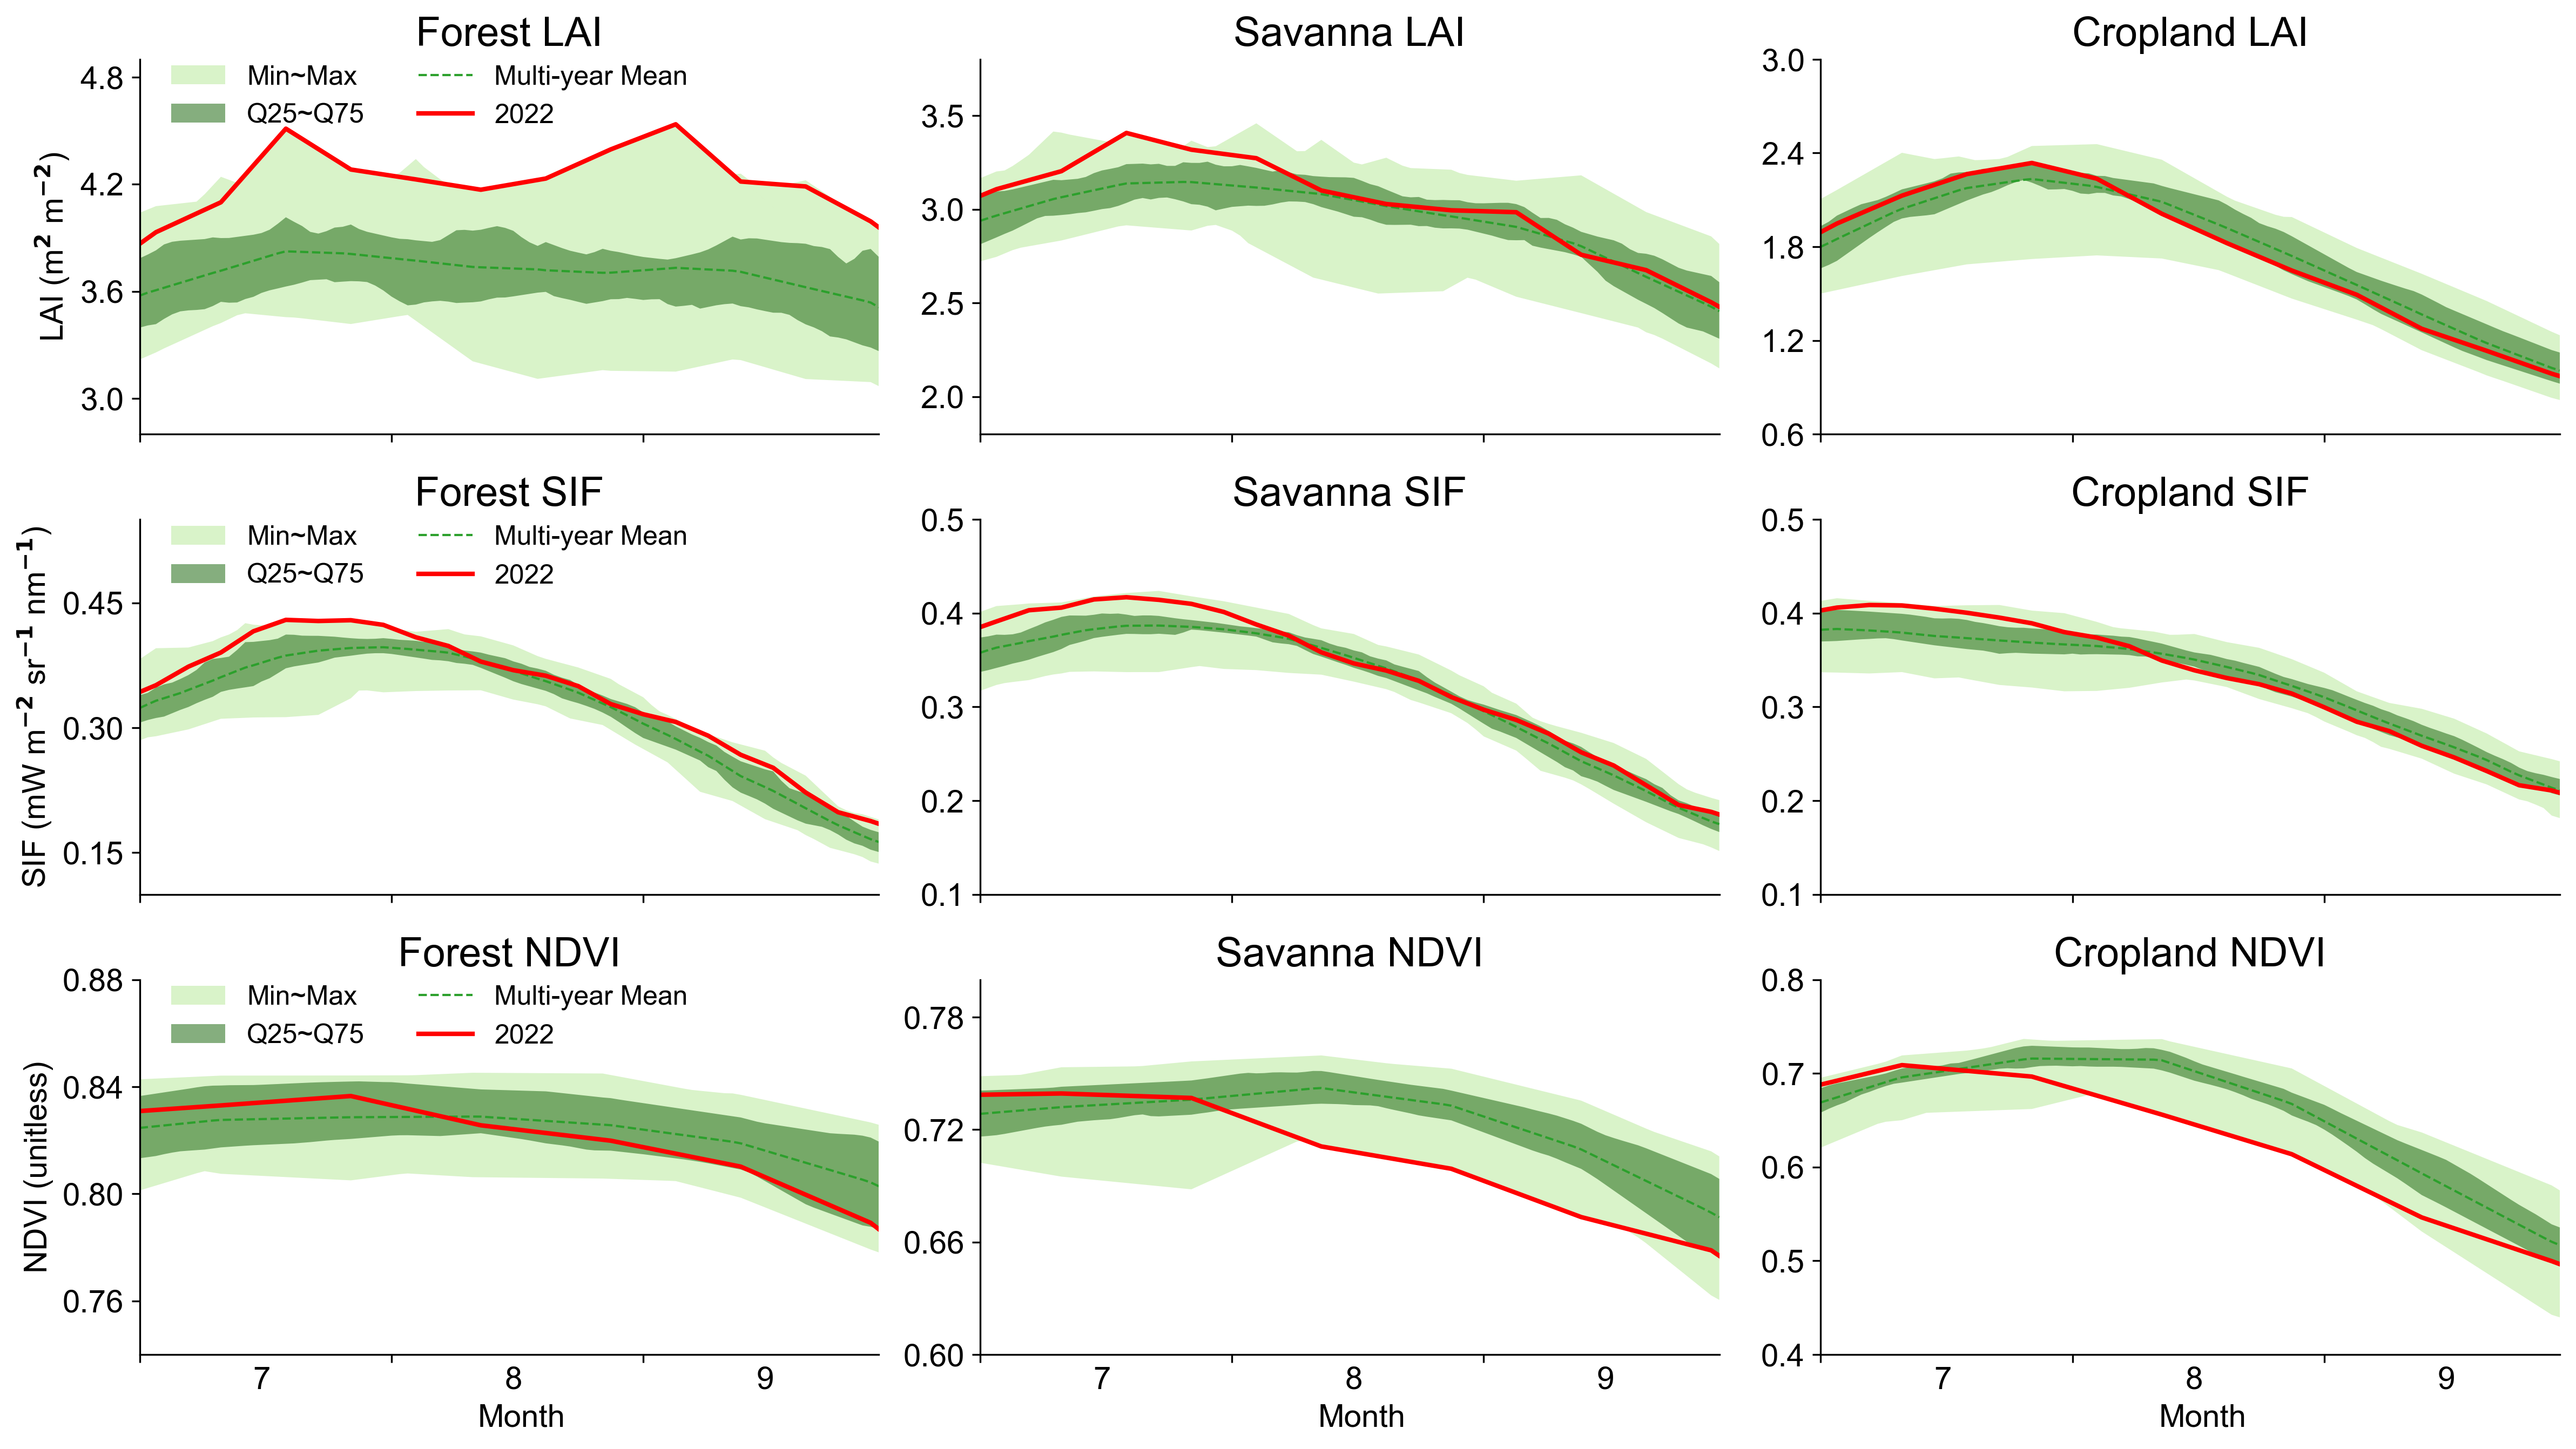

In [7]:
from matplotlib.ticker import MaxNLocator
fig, axes = plt.subplots(3,3,dpi=300,figsize=(16,9))
date = np.arange(1,93)

axes_flat = axes.flatten()
data = [y_mat1,y_mat2,y_mat3,y_mat4,y_mat5,y_mat6,y_mat7,y_mat8,y_mat9]
title = ['Forest LAI','Savanna LAI','Cropland LAI','Forest SIF','Savanna SIF','Cropland SIF','Forest NDVI','Savanna NDVI','Cropland NDVI']
ylabel = ['LAI (m$\mathbf{^{2}}$ m$\mathbf{^{-2}}$)','LAI (m$\mathbf{^{2}}$ m$\mathbf{^{-2}}$)','LAI (m$\mathbf{^{2}}$ m$\mathbf{^{-2}}$)',
           'SIF (mW m$\mathbf{^{-2}}$ sr$\mathbf{^{-1}}$ nm$\mathbf{^{-1}}$)','SIF (mW m$\mathbf{^{-2}}$ sr$\mathbf{^{-1}}$ nm$\mathbf{^{-1}}$)','SIF (mW m$\mathbf{^{-2}}$ sr$\mathbf{^{-1}}$ nm$\mathbf{^{-1}}$)',
           'NDVI (unitless)','NDVI (unitless)','NDVI (unitless)']

for i, ax in enumerate(axes_flat):
    if i < len(data):  # Ensure we don't exceed the number of data arrays
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.axvline(x=182, color='dimgrey', linestyle='--', lw=0.8)
        # ax.axvline(x=274, color='dimgrey', linestyle='--', lw=0.8)
        ax.fill_between(date, np.nanpercentile(data[i][182:274,:],q=0,axis=1),np.nanpercentile(data[i][182:274,:],q=100,axis=1), color='#C0EBA6',alpha=0.6,label='Min~Max',edgecolor='none')
        ax.fill_between(date, np.nanpercentile(data[i][182:274,:],q=25,axis=1),np.nanpercentile(data[i][182:274,:],q=75,axis=1), color='#347928',alpha=0.6,label='Q25~Q75',edgecolor='none')
        ax.plot(date,np.nanmean(data[i][182:274,:],axis=1),lw=1,ls='--',color='tab:green', label='Multi-year Mean')
        ax.plot(date, data[i][182:274,-1],color='r',lw=2,label='2022')
        ax.set_xlim(date[0], date[-1])
        ax.set_xticks([1, 32, 63])
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.set_ylabel('')
        ax.set_title(title[i], fontsize=18)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
        ax.tick_params(axis='y', labelsize=14)
        if i == 0 or i == 3 or i == 6:
            ax.set_ylabel(ylabel[i], fontsize=14)

        


axes[0,0].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=2, frameon=False, fontsize=12)
axes[1,0].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=2, frameon=False, fontsize=12)
axes[2,0].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=2, frameon=False, fontsize=12)
axes[0,0].set_ylim(2.8,4.9)
axes[0,1].set_ylim(1.8,3.8)
axes[0,2].set_ylim(0.6,3)
axes[1,0].set_ylim(0.1,0.55)
axes[1,1].set_ylim(0.1,0.5)
axes[1,2].set_ylim(0.1,0.5)
axes[2,0].set_ylim(0.74,0.88)
axes[2,1].set_ylim(0.6,0.8)
axes[2,2].set_ylim(0.4,0.8)

new_positions = [16, 47, 78]
xticklabels = ['7', '8', '9']
for i, ax in enumerate(axes_flat):  # Bottom row of subplots
    # Keep the original ticks
    ax.set_xticks([1, 32, 63])
    ax.set_xticklabels([])  # Hide the default labels
    if i == 6 or i == 7 or i == 8:
        for label, pos in zip(xticklabels, new_positions):
            ax.text(
                pos, 
                ax.get_ylim()[0] - 0.07 * (ax.get_ylim()[1] - ax.get_ylim()[0]),  # Slightly below the plot
                label, 
                ha='center', 
                va='center', 
                fontsize=14
            )
        ax.text(48, ax.get_ylim()[0] - 0.17 * (ax.get_ylim()[1] - ax.get_ylim()[0]), 'Month', ha='center', va='center', fontsize=14)

plt.tight_layout()
plt.savefig(outpath+'4.eps', dpi=300, bbox_inches='tight') 
plt.show()

## sm

In [4]:
sm0 = xr.open_dataset(inpath+'shapley/sm_new_0.05_1d.nc').sel(time = slice('2016-01-01', '2022-12-31'))

ds1 = varimask_forest(sm0)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2016-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat1 = y_list.reshape((365, -1), order='F')

ds1 = varimask_shrub(sm0)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2016-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat2 = y_list.reshape((365, -1), order='F')

ds1 = varimask_crop(sm0)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2016-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat3 = y_list.reshape((365, -1), order='F')

C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2105116616.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2105116616.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  y = ds.dims['lat']


Forest mask ratio: 84.22%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2105116616.py:17: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):    #### change the time length
C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2105116616.py:32: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2105116616.py:33: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths,

Shrubland mask ratio: 87.93%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2105116616.py:57: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2105116616.py:58: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  y = ds.dims['lat']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2105116616.py:68: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range

Crop mask ratio: 41.56%


In [5]:
sm1 = xr.open_dataset(inpath+'shapley/sm_new_0.05_1d.nc').sel(time = slice('2022-01-01', '2022-12-31'))

ds1 = varimask_forest(sm1)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat4 = y_list.reshape((365, -1), order='F')

ds1 = varimask_shrub(sm1)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat5 = y_list.reshape((365, -1), order='F')

ds1 = varimask_crop(sm1)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat6 = y_list.reshape((365, -1), order='F')

C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2105116616.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2105116616.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  y = ds.dims['lat']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2105116616.py:17: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(d

Forest mask ratio: 84.22%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2105116616.py:32: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2105116616.py:33: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  y = ds.dims['lat']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2105116616.py:43: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range

Shrubland mask ratio: 87.93%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2105116616.py:57: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2105116616.py:58: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  y = ds.dims['lat']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2105116616.py:68: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range

Crop mask ratio: 41.56%


In [6]:
df = pd.DataFrame(y_mat1, columns=[f'Column_{i+1}' for i in range(y_mat1.shape[1])])
df_roll = df.rolling(window=10).mean()
df_roll = df_roll.fillna(method='bfill')
a1 = df_roll.values*100

df = pd.DataFrame(y_mat2, columns=[f'Column_{i+1}' for i in range(y_mat2.shape[1])])
df_roll = df.rolling(window=10).mean()
df_roll = df_roll.fillna(method='bfill')
a2 = df_roll.values*100

df = pd.DataFrame(y_mat3, columns=[f'Column_{i+1}' for i in range(y_mat3.shape[1])])
df_roll = df.rolling(window=10).mean()
df_roll = df_roll.fillna(method='bfill')
a3 = df_roll.values*100

df = pd.DataFrame(y_mat4, columns=[f'Column_{i+1}' for i in range(y_mat4.shape[1])])
df_roll = df.rolling(window=10).mean()
df_roll = df_roll.fillna(method='bfill')
a4 = df_roll.values*100

df = pd.DataFrame(y_mat5, columns=[f'Column_{i+1}' for i in range(y_mat5.shape[1])])
df_roll = df.rolling(window=10).mean()
df_roll = df_roll.fillna(method='bfill')
a5 = df_roll.values*100

df = pd.DataFrame(y_mat6, columns=[f'Column_{i+1}' for i in range(y_mat6.shape[1])])
df_roll = df.rolling(window=10).mean()
df_roll = df_roll.fillna(method='bfill')
a6 = df_roll.values*100

C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2368287809.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_roll = df_roll.fillna(method='bfill')
C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2368287809.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_roll = df_roll.fillna(method='bfill')
C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2368287809.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_roll = df_roll.fillna(method='bfill')
C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\2368287809.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_roll = df_roll.fillna(method='bfill')
C:\Users\bn_li

C:\Users\bn_li\AppData\Local\Temp\ipykernel_25124\4045068228.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(182,274, color='lightgray', alpha=0.2, edgecolor='none', linewidth=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


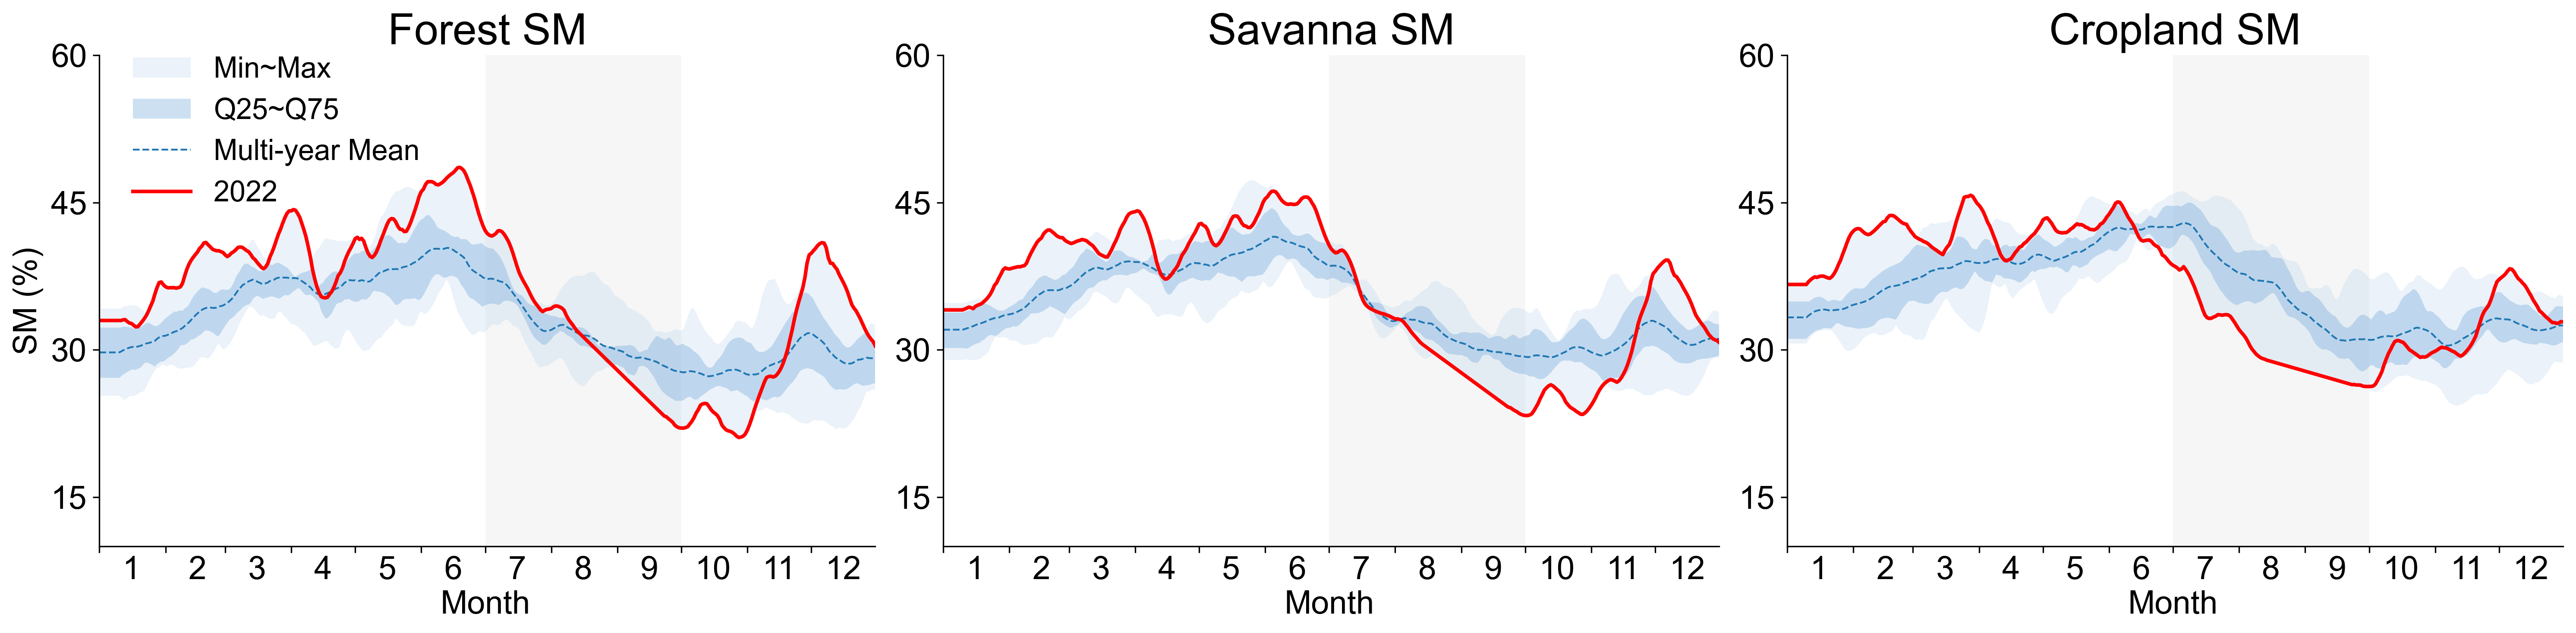

In [7]:
from matplotlib.ticker import MaxNLocator
fig, axes = plt.subplots(1,3,dpi=300,figsize=(20,5))
date = np.arange(1,366)
date1 = np.arange(1,366)
axes_flat = axes.flatten()
data = [a1,a2, a3]
data1 = [a4,a5,a6]
title = ['Forest SM','Savanna SM','Cropland SM']
for i, ax in enumerate(axes_flat):
    if i < len(data):  # Ensure we don't exceed the number of data arrays
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.axvspan(182,274, color='lightgray', alpha=0.2, edgecolor='none', linewidth=0)
        ax.fill_between(date, np.nanpercentile(data[i],q=0,axis=1),np.nanpercentile(data[i],q=100,axis=1), color='#BDD7EE',alpha=0.3,label='Min~Max',edgecolor='none')
        ax.fill_between(date, np.nanpercentile(data[i],q=25,axis=1),np.nanpercentile(data[i],q=75,axis=1), color='#599AD7',alpha=0.3,label='Q25~Q75',edgecolor='none')
        ax.plot(date,np.nanmean(data[i],axis=1),lw=1,ls='--',color='tab:blue', label='Multi-year Mean')
        ax.plot(date1, data1[i],color='r',lw=2,label='2022')
        ax.set_xlim(date[0], date[-1])
        ax.set_xticks([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.set_title(title[i], fontsize=24)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
        ax.tick_params(axis='y', labelsize=18)
        ax.set_ylim(10,60)
        ax.text(182, ax.get_ylim()[0] - 0.12 * (ax.get_ylim()[1] - ax.get_ylim()[0]), 'Month', ha='center', va='center', fontsize=18)

new_positions = [16, 47, 75, 106, 136, 167, 197, 228, 259, 289, 320, 350]
xticklabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
for ax in axes_flat:  # Bottom row of subplots
    # Keep the original ticks
    ax.set_xticks([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
    ax.set_xticklabels([])  # Hide the default labels

    # Add new labels at the desired positions
    for label, pos in zip(xticklabels, new_positions):
        ax.text(
            pos, 
            ax.get_ylim()[0] - 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0]),  # Slightly below the plot
            label, 
            ha='center', 
            va='center', 
            fontsize=18
        )
axes_flat[0].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=16)
axes_flat[0].set_ylabel('SM (%)',fontsize=18)
# plt.subplots_adjust(wspace=0.05, hspace=0.3)
plt.tight_layout()
plt.savefig(outpath+'6.eps', dpi=300, bbox_inches='tight') 
plt.show()